# XGBoost: Extreme Gradiente Boosting

The example is from https://www.datacamp.com/community/tutorials/xgboost-in-python. The analisis presented is interesting. We use Boston House Prices data to show an example of xgboost.

In [ ]:
#!pip install xgboost

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_boston, fetch_california_housing, load_wine

from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

Vamos a utilizar dos bases de datos para predecir el precio de una casa:

In [137]:
boston = load_boston()
california = fetch_california_housing()

In [138]:
data_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
data_california = pd.DataFrame(california.data, columns=california.feature_names)

We first take a look at the data

In [139]:
data_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [140]:
data_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Column names are not that helpful, if you want to know about them, look at the description below:

In [141]:
print(boston.DESCR)
print(california.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

The objective will be to predict the properties prices, we add that info in a new column:

In [142]:
data_boston['PRICE'] = boston.target
data_california['PRICE'] = california.target

In [143]:
Xb, yb = data_boston.iloc[:,:-1],data_boston.iloc[:,-1]
Xc, yc = data_california.iloc[:,:-1],data_california.iloc[:,-1]

The next step is just an optimization for performance...

In [144]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=50)

In [145]:
Xb_train.shape, Xc_train.shape

((404, 13), (16512, 8))

Create the model and train it. The APIs are similar to the ones of sklearn :)

XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...)
RMSE: 9.068350


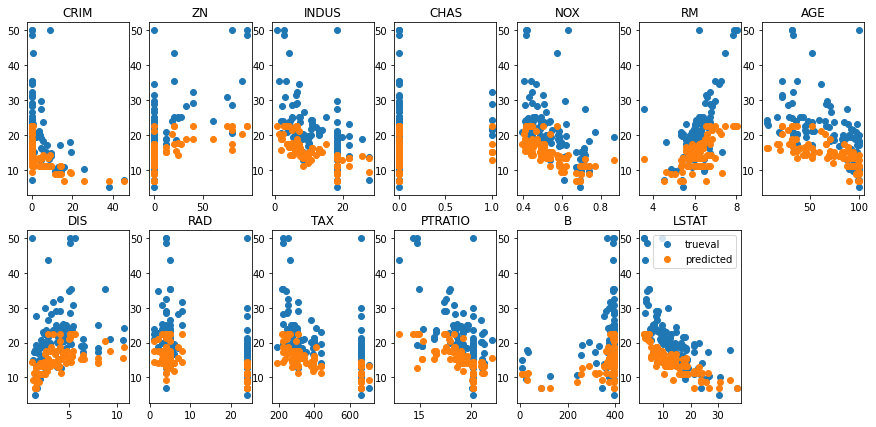

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               predictor=None, random_state=None, reg_alpha=None,
               sampling_method=None, scale_pos_weight=None, ...)
RMSE: 2.932305


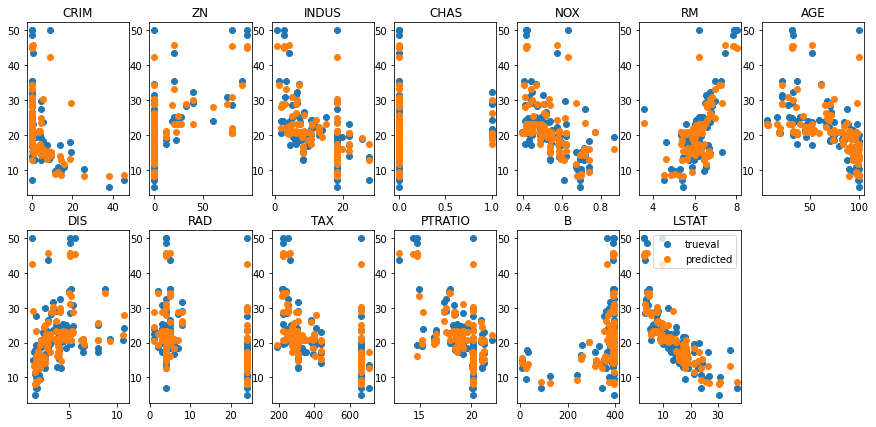

XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...)
RMSE: 1.024443


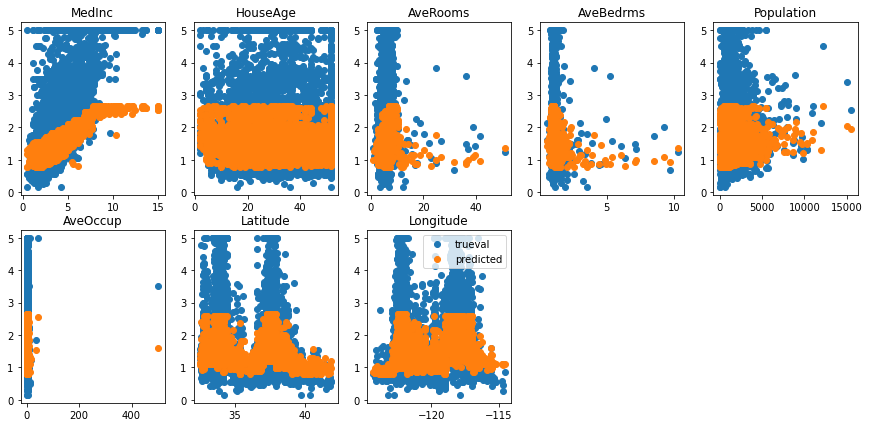

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               predictor=None, random_state=None, reg_alpha=None,
               sampling_method=None, scale_pos_weight=None, ...)
RMSE: 0.629644


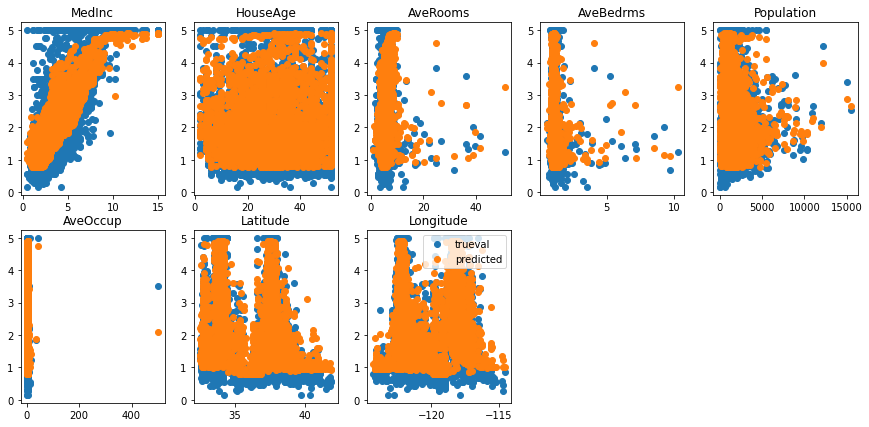

In [167]:
argumentos = dict(objective ='reg:squarederror',
                         colsample_bytree = 0.3,
                         learning_rate = 0.2,
                         max_depth = 10, 
                         alpha = 50, 
                         n_estimators = 5) #jugar con esto

xg_regb = [XGBRegressor(**argumentos), 
        XGBRFRegressor()]

xg_regc = [XGBRegressor(**argumentos),
        XGBRFRegressor()]

boston_set = (xg_regb, Xb_train, yb_train, Xb_test, yb_test)
california_set = (xg_regc, Xc_train, yc_train, Xc_test, yc_test)

for (dataset_models, X_train, y_train, X_test, y_test) in (boston_set, california_set):
    for model in dataset_models:
        print(model)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        print("RMSE: %f" % (rmse))

        plt.figure(figsize=(15,7))
        for i, var in enumerate(X_test):
            plt.subplot(2, int(X_test.shape[1]/2) + 1, i+1)
            plt.scatter(X_test.loc[:,var],y_test, label='trueval')
            plt.scatter(X_test.loc[:,var],preds, label='predicted')
            plt.title(var)
        plt.legend()
        plt.show()


# Y para problemas de clasificación?

In [207]:
from sklearn.model_selection import KFold

In [222]:
iris = load_wine()

X = iris["data"]
y = iris["target"]

FOLDS=4
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=4)

El parámetro `objective` es la función objetivo a minimizar. Para problemas de clasificación multiclase usualmente usamos `multi:softmax` debido a que da una "probabilidad" para cada clase. 

Tiene la forma:

$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K{e^{z_j}}}$ para $i=1, \dots, K$ y $\mathbf{z} = (z_1, \dots, z_K) \in \mathbb{R}^K $

Se puede ver la [documentacion](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters) para otras funciones objetivo.

In [223]:
clfs = [XGBClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10),
        XGBRFClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10),
        RandomForestClassifier()]

clfs_names = ['XGBC', 'XGBRFC', 'RF']


XGBC
Acc. fold 1: 95.56
Acc. fold 2: 95.56
Acc. fold 3: 100.00
Acc. fold 4: 97.73
Avg. accuracy = 97.20959595959597
XGBRFC
Acc. fold 1: 95.56
Acc. fold 2: 95.56
Acc. fold 3: 100.00
Acc. fold 4: 90.91
Avg. accuracy = 95.50505050505052
RF
Acc. fold 1: 97.78
Acc. fold 2: 97.78
Acc. fold 3: 97.73
Acc. fold 4: 97.73
Avg. accuracy = 97.75252525252525


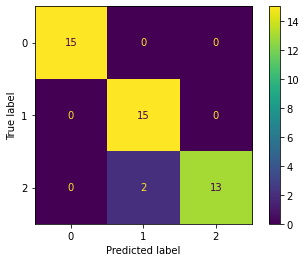

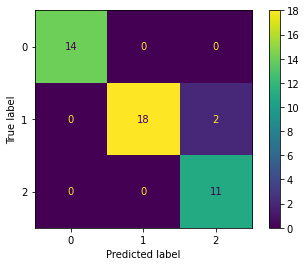

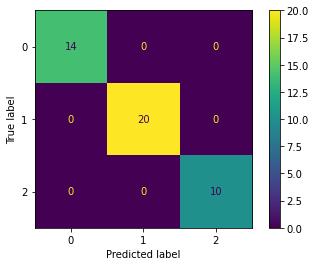

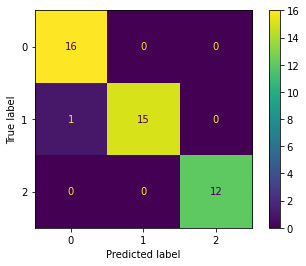

In [226]:
for clf, name in zip(clfs, clfs_names):
    avg_accuracy = 0
    print(name)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[val_idx], y[val_idx]
        clf.fit(X_train,y_train)
        preds = clf.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        avg_accuracy +=accuracy
        print(f"Acc. fold {fold+1}: {accuracy * 100.0 :.2f}" % ())
        if name == 'XGBC':
            ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')